In [1]:
!pip install --upgrade pip
!pip install pymongo
!pip install wordcloud
!pip install pandas
!pip install matplotlib
!pip install -U nltk

    100% |████████████████████████████████| 1.4MB 5.0MB/s 
  Found existing installation: pip 19.0.2
    Uninstalling pip-19.0.2:
      Successfully uninstalled pip-19.0.2
    100% |████████████████████████████████| 409kB 6.1MB/s 
    100% |████████████████████████████████| 368kB 8.9MB/s 
    100% |████████████████████████████████| 17.3MB 731kB/s 
    100% |████████████████████████████████| 2.0MB 12.7MB/s 
    100% |████████████████████████████████| 10.1MB 3.7MB/s 
    100% |████████████████████████████████| 512kB 4.5MB/s 
    100% |████████████████████████████████| 13.0MB 2.6MB/s 
    100% |████████████████████████████████| 92kB 19.1MB/s 
    100% |████████████████████████████████| 71kB 10.4MB/s 
    100% |████████████████████████████████| 1.4MB 12.0MB/s 
  Stored in directory: /home/jovyan/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk


In [3]:
from pymongo import MongoClient
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='ds145639.mlab.com', port='45639', username='collector', password='collector123', no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    #if no_id:
    #    del df['_id']

    return df


In [11]:
query = {'$and': [ {'retweeted':False}, {'quoted':False},{'lang':"pt"},
                                         {'$or': [ 
                                             {'texto':{'$regex':u'acidente'}},                                             
                                             {'texto':{'$regex':u'colisao'}},
                                             {'texto':{'$regex':u'colisão'}},
                                             {'texto':{'$regex':u'capotamento'}},
                                             {'texto':{'$regex':u'batida'}},                        
                                             {'texto':{'$regex':u'trânsito'}},
                                             {'texto':{'$regex':u'choque'}},
                                             {'texto':{'$regex':u'engavetamento'}},
                                             {'texto':{'$regex':u'motoqueiro'}},
                                             {'texto':{'$regex':u'motocicleta'}},
                                             {'texto':{'$regex':u'sinistro'}},
                                             {'texto':{'$regex':u'desastre'}},
                                             {'texto':{'$regex':u'incidente'}},
                                             {'texto':{'$regex':u'veículo'}}
                                        ]}]}

people = read_mongo('landing_zone','people_data',query=query)
posts = read_mongo('landing_zone','posts_data',query=query)
full_data = people.append(posts)

full_data.head(5)

,_id,coordinates,data,geo,hashtags,id,lang,location,place,quoted,retweeted,texto,urls,user_mentions,usuario
0,5c74434d8796370b2cfc8118,None,Mon Feb 25 19:34:32 +0000 2019,None,[],1100116855048626181,pt,"Penha, São Paulo","{'id': '68e019afec7d0ba5', 'url': 'https://api...",False,False,"@CETSP_ rua Canguaretama, altura do 45 solicit...","[{'url': 'https://t.co/3JzWP68MKd', 'expanded_...","[{'screen_name': 'CETSP_', 'name': 'CET São Pa...",Depdiego
1,5c79798b8796370b2cfc858a,None,Fri Mar 01 18:26:40 +0000 2019,None,[],1101549329851011073,pt,"São Paulo, Brasil",None,False,False,@CETSP_ 1 semana sem semáforo funcionado ou a...,[],"[{'screen_name': 'CETSP_', 'name': 'CET São Pa...",AndSidou
2,5c7979cf8796370b2cfc858c,None,Fri Mar 01 18:28:25 +0000 2019,None,[],1101549770676547584,pt,Sampa,None,False,False,"@DetranSP , me tira uma dúvida? Existe no Códi...","[{'url': 'https://t.co/wCa5474W6U', 'expanded_...","[{'screen_name': 'DetranSP', 'name': 'Detran S...",juhiromi
3,5c797c698796370b2cfc85ad,None,Fri Mar 01 18:39:32 +0000 2019,None,[],1101552565332987916,pt,"São Paulo, Brasil",None,False,False,@_ecovias Alguma explicação do pq a alça de ac...,"[{'url': 'https://t.co/yxhLM7zJpg', 'expanded_...","[{'screen_name': '_ecovias', 'name': 'Ecovias'...",fogaovermelho
4,5c797d038796370b2cfc85b1,None,Fri Mar 01 18:42:06 +0000 2019,None,"[{'text': 'VilaEsperança', 'indices': [55, 69]...",1101553212304302082,pt,São Paulo - SP,None,False,False,Esquema especial de trânsito será montado na r...,"[{'url': 'https://t.co/NHG8SPxUHF', 'expanded_...",[],CETSP_


In [12]:
print("A quantidade total de registros é: {}".format(len(full_data)))

A quantidade total de registros é: 19291


In [13]:
import dateutil.parser

In [14]:
datetime_str = "Fri Feb 15 19:00:03 +0000 2019"  # Datestring in ISO 8601 format
some_datetime_obj = dateutil.parser.parse(datetime_str)

In [15]:
print(some_datetime_obj)

2019-02-15 19:00:03+00:00


In [16]:
def remove_urls(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text)

def to_lower(text):
    return text.lower()

format_date_time = lambda s: dateutil.parser.parse(datetime_str)
get_month = lambda d: d.month
get_day = lambda d: d.day

In [17]:
full_data['formatted_date'] = full_data['data'].apply(func=lambda string: dateutil.parser.parse(string))
full_data['mes'] = full_data['formatted_date'].apply(func=lambda date: date.month)
full_data['dia'] = full_data['formatted_date'].apply(func=lambda date: date.day)
full_data['ano'] = full_data['formatted_date'].apply(func=lambda date: date.year)
full_data['hora'] = full_data['formatted_date'].apply(func=lambda date: date.hour)
full_data['minuto'] = full_data['formatted_date'].apply(func=lambda date: date.minute)

full_data['texto_formatado'] = full_data['texto'].apply(lambda t: remove_urls(str(t)))
full_data['texto_formatado'] = full_data['texto_formatado'].apply(lambda t: to_lower(t))

In [18]:
tokenizer = TreebankWordTokenizer()
full_data['tokens'] = full_data['texto_formatado'].apply(lambda t: tokenizer.tokenize(t))
full_data[['texto_formatado','tokens']].head()

,texto_formatado,tokens
0,"@cetsp_ rua canguaretama, altura do 45 solicit...","[@, cetsp_, rua, canguaretama, ,, altura, do, ..."
1,@cetsp_ 1 semana sem semáforo funcionado ou a...,"[@, cetsp_, 1, semana, sem, semáforo, funciona..."
2,"@detransp , me tira uma dúvida? existe no códi...","[@, detransp, ,, me, tira, uma, dúvida, ?, exi..."
3,@_ecovias alguma explicação do pq a alça de ac...,"[@, _ecovias, alguma, explicação, do, pq, a, a..."
4,esquema especial de trânsito será montado na r...,"[esquema, especial, de, trânsito, será, montad..."


In [19]:
len(full_data)

19291

In [20]:
def create_stopword_list():
    portuguese_stops = set(stopwords.words('portuguese'))
    portuguese_stops.add('rt')

    with open('punctuation.txt','r+') as punct_file:
        puncts = punct_file.readlines()

    for item in puncts:    
        portuguese_stops.add(item.strip())
        
    return portuguese_stops

stop_w = create_stopword_list()

#aplica a remocao de stop-words
full_data['words'] = full_data['tokens'].apply(lambda w: [word for word in w if word not in stop_w]) 
#exibe resultado intermediario
full_data[['tokens','words']].head(10)

,tokens,words
0,"[@, cetsp_, rua, canguaretama, ,, altura, do, ...","[cetsp_, rua, canguaretama, altura, 45, solici..."
1,"[@, cetsp_, 1, semana, sem, semáforo, funciona...","[cetsp_, 1, semana, semáforo, funcionado, agen..."
2,"[@, detransp, ,, me, tira, uma, dúvida, ?, exi...","[detransp, tira, dúvida, existe, código, trâns..."
3,"[@, _ecovias, alguma, explicação, do, pq, a, a...","[_ecovias, alguma, explicação, pq, alça, acess..."
4,"[esquema, especial, de, trânsito, será, montad...","[esquema, especial, trânsito, montado, região,..."
5,"[que, situação, !, -, na, rua, barão, do, pira...","[situação, rua, barão, piraí, 278, vila, prude..."
6,"[acidente, entre, quatro, veículos, na]","[acidente, quatro, veículos]"
7,"[estradas, -, a, pista, lateral, da, rodovia, ...","[estradas, pista, lateral, rodovia, ayrton, se..."
8,"[o, trânsito, será, monitorado, na, #, zc, ,, ...","[trânsito, monitorado, zc, sábado, 02, terça, ..."
9,"[⚽, embate, entre, @, corinthians, x, @, racin...","[⚽, embate, corinthians, x, racingclub, sudame..."


In [21]:
full_data['clean_text'] = full_data['words'].apply(lambda t: str(' '.join(t)))

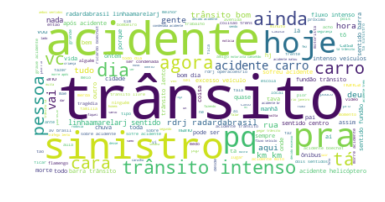

In [22]:
# Start with one review:
text = 'processamento dos dados requer potentes plataformas de hardware, com alta escalabilidade e desempenho'
text = " ".join(texto for texto in full_data.clean_text)
#print(text)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figsize=[500,500]
#plt.figure(figsize=[10,10])
#plt.figure(figsize=[20,10])
#plt.show()

In [23]:
dias = full_data.groupby(['dia']).count()['_id']

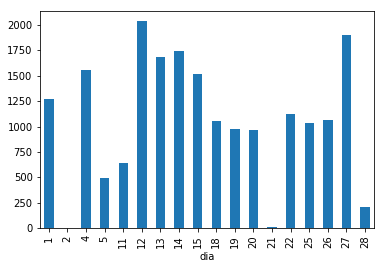

In [24]:
dias.plot(kind='bar')

In [56]:
file = open('words','w+')
file.write(text)

6254619